# Linear Elasticity Fracture Mechanics

*Authors:* 
- *Laura De Lorenzis (ETH Zürich)*
- *Veronique Lazarus (ENSTA, IPP)*
- *Corrado Maurini (Sorbonne Université, corrado.maurini@sorbonne-universite.fr)*

This notebook serves as a tutorial for linear elastic fracture mechanics


In [8]:
import sys
sys.path.append("python")

# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import dolfinx.fem as fem
import dolfinx.mesh as mesh
import dolfinx.io as io
import dolfinx.plot as plot
import ufl

from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType


plt.rcParams["figure.figsize"] = (6,3)

outdir = "output"
from pathlib import Path
Path(outdir).mkdir(parents=True, exist_ok=True)


# Asymptotic field and SIF ($K_I$)

Let us first get the elastic solution for a given crack length 

In [9]:
from elastic_solver import solve_elasticity

Lcrack = 0.3
Lx = 1.
uh, energy, sigma_ufl = solve_elasticity(Lx=Lx,Ly=.5,Lcrack=Lcrack,lc=.05,refinement_ratio=30,dist_min=.2,dist_max=.3)


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00317683s, CPU 0.003871s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.740616s, CPU 0.738907s)
Info    : 27914 nodes 55831 elements
The potential energy for Lcrack=3.000e-01 is -4.107e-01


In [10]:
from utils import warp_plot_2d
import pyvista
pyvista.set_jupyter_backend("pythreejs")
# Other possible pyvista backend if the current one is not working:
# "ipyvtklink", "panel", "pythreejs", "static", "pythreejs", "none"

import ufl
sigma_iso = 1./3*ufl.tr(sigma_ufl)*ufl.Identity(uh.geometric_dimension())
sigma_dev =  sigma_ufl - sigma_iso
von_Mises = ufl.sqrt(3./2*ufl.inner(sigma_dev, sigma_dev))
V_dg = fem.FunctionSpace(uh.function_space.mesh, ("DG", 0))
stress_expr = fem.Expression(von_Mises, V_dg.element.interpolation_points())
vm_stress = fem.Function(V_dg)
vm_stress.interpolate(stress_expr)
plotter = warp_plot_2d(uh,cell_field=vm_stress,field_name="Von Mises stress", factor=.1,show_edges=False,clim=[0, 10])
pyvista.OFF_SCREEN = True
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb(wait=0.1)
    figure = plotter.screenshot(f"{outdir}/VonMises.png")

## Crack opening displacement (COD)

Let us get the vertical displacement at the crack lip

In [6]:
from utils import evaluate_on_points, warp_plot_2d
xs = np.linspace(0,Lcrack,100)
ys = 0.0 * np.ones_like(xs)
zs = 0.0 * np.ones_like(xs)
points = np.array([xs,ys,zs])
u_values = evaluate_on_points(uh,points)
us = u_values[:,1]


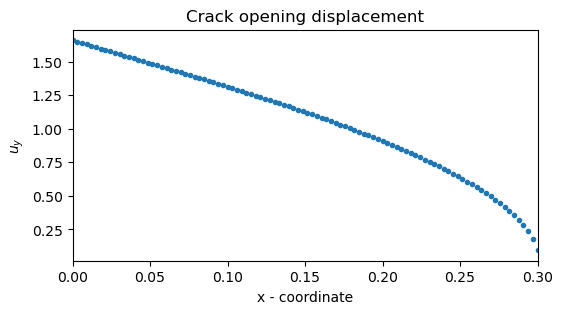

In [11]:
plt.plot(xs,us,".")
plt.xlim([0.,Lcrack])
plt.xlabel("x - coordinate")
plt.ylabel(r"$u_y$")
plt.title("Crack opening displacement")
plt.savefig(f"{outdir}/COD.png")

As detailed in the lectures notes, we can estimate the value of the stress intensity factor $K_I$ by extrapolating $u \sqrt{2\pi/ r}$

  plt.semilogx(r,us*np.sqrt(2*np.pi/r)*factor,".")



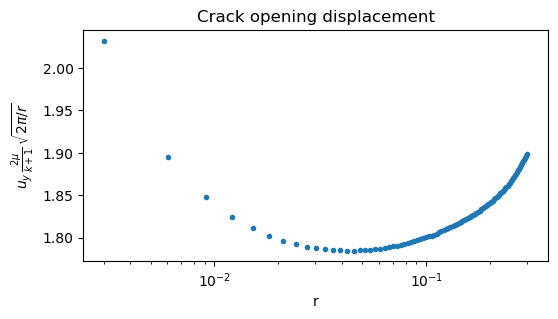

In [12]:
r = (Lcrack-xs)
#r_ = r[np.where(xs<Lcrack)]
#us_ = us[np.where(xs<Lcrack)]

nu = 0.3
E = 1.0
mu = E / (2.0 * (1.0 + nu))
kappa = (3 - nu) / (1 + nu)
factor = 2 * mu / (kappa + 1)

plt.semilogx(r,us*np.sqrt(2*np.pi/r)*factor,".")
plt.xlabel("r")
plt.ylabel(r"${u_y} \,\frac{2\mu}{k+1} \,\sqrt{2\pi/r}$")
plt.title("Crack opening displacement")
plt.savefig(f"{outdir}/KI-COD.png")

We estimate $K_I\simeq 1.8\pm0.1$

## Stress at the crack tip

Let us get the stress around the crack tip

In [13]:
xs = np.linspace(Lcrack,2*Lcrack,1000)
ys = 0.0 * np.ones_like(xs)
zs = 0.0 * np.ones_like(xs)
points = np.array([xs,ys,zs])
r = (xs-Lcrack)
sigma_xx_expr = fem.Expression(sigma_ufl[0,0], V_dg.element.interpolation_points())
sigma_xx = fem.Function(V_dg)
sigma_xx.interpolate(sigma_xx_expr)
sigma_xx_values = evaluate_on_points(sigma_xx,points)

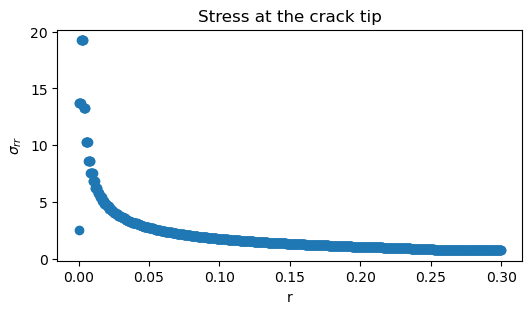

In [14]:
plt.plot(r,sigma_xx_values[:,0],"o")
plt.xlabel("r")
plt.ylabel(r"$\sigma_{rr}$")
plt.title("Stress at the crack tip")
plt.savefig(f"{outdir}/stress.png")

As detailed in the lectures notes, we can estimate the value of the stress intensity factor $K_I$ by extrapolating $\sigma_{rr} \sqrt{2\pi r}$

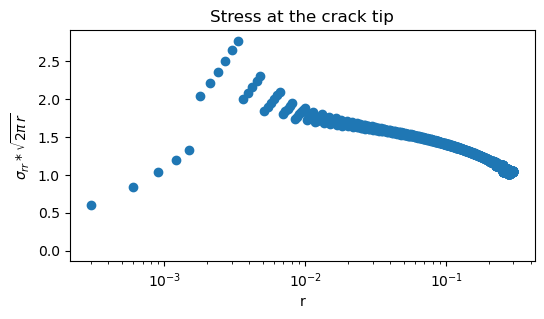

In [15]:
plt.semilogx(r,sigma_xx_values[:,0]*np.sqrt(2*np.pi*r),"o")
plt.xlabel("r")
plt.ylabel(r"$\sigma_{rr}*\sqrt{2\pi\,r}$")
plt.title("Stress at the crack tip")
plt.savefig(f"{outdir}/KI-stress.png")


We can say that $K_I\simeq 1.5\pm .5$ as from the COD, but this estimate is not precise and reliable. 

From Irwing formula in plane-stress, we get the energy release rate (ERR)


In [16]:
KI_estimate = 1.8 
G_estimate = KI_estimate ** 2 / E # Irwin's formula in plane stress
print(f"ERR estimate is {G_estimate}")

ERR estimate is 3.24


# The elastic energy release rate 

## Naïf method: finite difference of the potential energy

Let us first calculate the potential energy for several crack lengths. We multiply the result by 2 to account for the symmetry when comparing with the $K_I$ estimate above.

In [17]:
Ls = np.linspace(Lcrack*.7,Lcrack*1.3,10)
energies = np.zeros_like(Ls)
Gs = np.zeros_like(Ls)
for (i, L) in enumerate(Ls):
    uh, energies[i], _ = solve_elasticity(Lx=1,Ly=.5,Lcrack=L,lc=.1,refinement_ratio=10,dist_min=.2,dist_max=.3,verbosity=1)
    
energies = energies * 2

The potential energy for Lcrack=2.100e-01 is -3.158e-01
The potential energy for Lcrack=2.300e-01 is -3.327e-01
The potential energy for Lcrack=2.500e-01 is -3.524e-01
The potential energy for Lcrack=2.700e-01 is -3.756e-01
The potential energy for Lcrack=2.900e-01 is -4.025e-01
The potential energy for Lcrack=3.100e-01 is -4.338e-01
The potential energy for Lcrack=3.300e-01 is -4.695e-01
The potential energy for Lcrack=3.500e-01 is -5.097e-01
The potential energy for Lcrack=3.700e-01 is -5.555e-01
The potential energy for Lcrack=3.900e-01 is -6.073e-01


We can estimate the ERR by taking the finite-difference approximation of the derivative

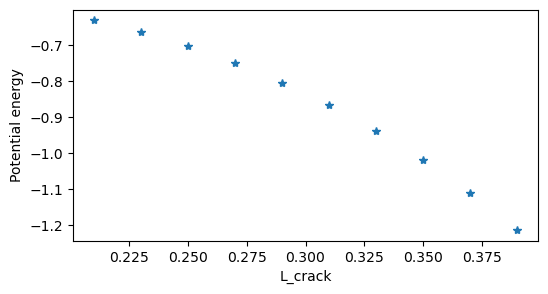

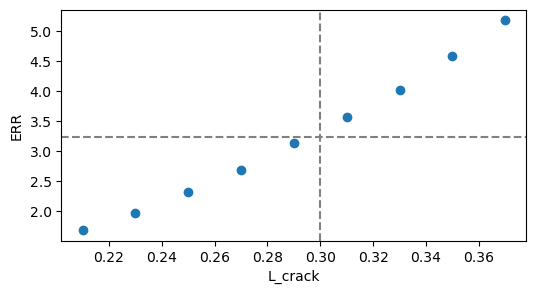

In [18]:
ERR_naif = -np.diff(energies)/np.diff(Ls)

plt.figure()
plt.plot(Ls, energies,"*")
plt.xlabel("L_crack")
plt.ylabel("Potential energy")
plt.figure()
plt.plot(Ls[0:-1], ERR_naif,"o")
plt.ylabel("ERR")
plt.xlabel("L_crack")
plt.axhline(G_estimate,linestyle='--',color="gray")
plt.axvline(Lcrack,linestyle='--',color="gray") 